In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax.experimental import sparse

from rgm import *
from atari.common import *

/home/tverbele/Code/python/rgm/.venv/lib/python3.11/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


In [3]:
env = make_game(game_config("Breakout", ObservationType.MINI))

In [4]:
@jax.jit
def to_one_hot(o):
    """
    Convert observation of  10 x 10 x n to 100 x n+1
    where we add channel for zero (background) values 
    """
    zero_mask = jnp.sum(o, axis=-1, keepdims=-1) == 0
    arr = jnp.concatenate([o, zero_mask], axis=-1).astype(jnp.float32)
    arr = arr.reshape(-1, arr.shape[-1])
    return arr

In [5]:
import seaborn as sns
from matplotlib import colors


def render(observation):
    cmap = sns.color_palette("cubehelix", observation.shape[-1])
    cmap.insert(0, (0, 0, 0))
    cmap = colors.ListedColormap(cmap)
    bounds = [i for i in range(observation.shape[-1] + 2)]
    norm = colors.BoundaryNorm(bounds, observation.shape[-1] + 1)
    numerical_state = jnp.amax(observation * jnp.reshape(jnp.arange(observation.shape[-1]) + 1, (1, 1, -1)), 2) + 0.5
    img = cmap(norm(numerical_state))
    return img[:, :, :3]

In [6]:
from tqdm import tqdm

max_steps = 100

# store for inspecting / visualizing later
actions = []
observations = []
rewards = []

obs, info = env.reset()
ogm = OGM(size=(obs.shape[0],obs.shape[1]), 
          n_bins=obs.shape[2] + 1, 
          n_actions=env.action_space.n)


with tqdm(total=max_steps) as pbar:
    step = 0
    while step < max_steps:

        done = False
        obs, info = env.reset()
        while not done:
            step += 1
         
            action = env.action_space.sample()
            next_obs, reward, done, trunc, info = env.step(action)

            ogm.update_pB(to_one_hot(obs), to_one_hot(next_obs), action, reward)

            actions.append(action)
            observations.append(obs)
            rewards.append(reward)
            obs = next_obs

            pbar.update(1)

            if done:
                obs, info = env.reset()

            if step == max_steps:
                break

100%|██████████| 100/100 [00:36<00:00,  2.73it/s]


In [7]:
import mediapy

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos({"observations": [render(o) for o in observations]}, width=320, height=320, fps=10, codec="gif")

observations


In [8]:
ogm.update_B()

In [9]:
p = ogm.predict(to_one_hot(observations[10]), 0)

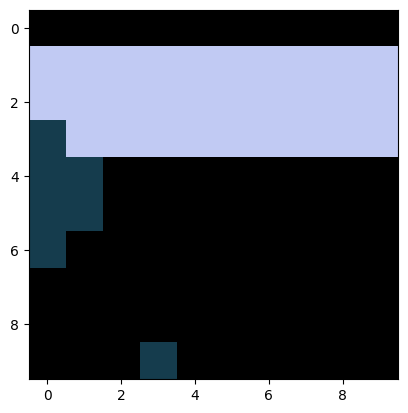

In [10]:
import matplotlib.pyplot as plt

plt.imshow(render(p.reshape(10, 10, ogm.n_bins)[:, :, :observations[0].shape[-1]]))

In [13]:
noop = ogm.rollout(to_one_hot(observations[0]), jnp.array([0, 0, 0, 0]))
left = ogm.rollout(to_one_hot(observations[0]), jnp.array([1, 1, 1, 1]))
right = ogm.rollout(to_one_hot(observations[0]), jnp.array([2, 2, 2, 2]))

noop,left,right

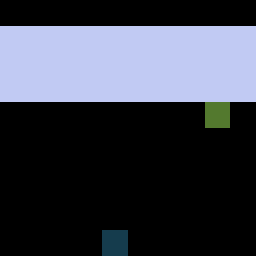
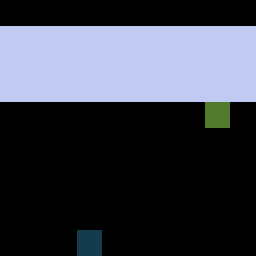
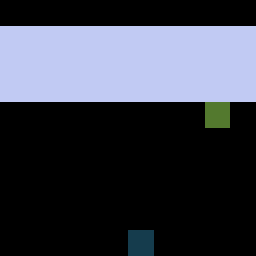

In [14]:
import mediapy
from PIL import Image

resize = lambda x: jnp.array(Image.fromarray((x * 255).astype(jnp.uint8)).resize((256, 256), Image.NEAREST))
imgs = {
    "noop": [resize(render(p.reshape(10, 10, ogm.n_bins)[:, :, :observations[0].shape[-1]])) for p in noop],
    "left": [resize(render(p.reshape(10, 10, ogm.n_bins)[:, :, :observations[0].shape[-1]])) for p in left],
    "right": [resize(render(p.reshape(10, 10, ogm.n_bins)[:, :, :observations[0].shape[-1]])) for p in right],
}

with mediapy.set_show_save_dir("/tmp"):
    mediapy.show_videos(
        imgs,
        width=320,
        height=320,
        fps=2,
        codec="gif",
    )